# Inferring an Approval Rating with Bernoulli Sampling
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\Ybar}{\overline{Y}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
$$
This notebook illustrates a simple model for estimating an approval rating (a population proportion) using a **Bernoulli** random variable model, simulated survey responses, and two kinds of confidence intervals:

- **Exact (Binomial) confidence interval** (via an exact binomial inversion / Clopper–Pearson style interval)
- **Central Limit Theorem (Normal approximation) confidence interval** (Wald interval)

> **Key idea:** If each respondent answers **Yes** (approve) / **No** (disapprove), we can model each response as a Bernoulli random variable  
$$
Y_i \sim \Bern(p),\quad i=1,\dots,n,
$$
where $p = \mu = \E(Y)$ is the (unknown) approval probability in the population.

We estimate $p=\mu$ with the sample proportion
$$
\Ybar = \frac{1}{n}\sum_{i=1}^n Y_i.
$$

- What is the **population**?  US adults, all 340 million
- Why are we **sampling**?  Because we cannot know what all of them think.
- Why do we think that we can know what they think?  If we do the sampling carefully, we only need about $1500$ or so responses to have a good idea.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import classlib as cl

%matplotlib inline

rng = np.random.default_rng(20251222)

cl.nbviz.init(use_tex=True)
colors = cl.nbviz.TOL_BRIGHT
cl.nbviz.configure(figpath="figures/approval_rating", savefigs=True, imgfrmt="png")

## Parameters

You can change these and re-run to generate a new simulated survey.

- $n$ : sample size (number of respondents)
- $p = \mu$ : the *true* (unknown) approval probability (used here only to simulate data)
- $1-\alpha$ : confidence level (e.g., 0.95 = 95%)


In [2]:
# Parameters (edit as desired)
n = 1500         # sample size
p_true = 0.36    # "true" approval probability (for simulation purposes)
alpha = 0.05     # 95% CI

# Simulate survey responses: 1 = Yes/Approve, 0 = No/Disapprove
y = rng.binomial(n=1, p=p_true, size=n)
tot = int(y.sum())          # number of Yes responses
ybar = tot / n              # sample proportion

print(f"For {n} people we have {tot} of them approving for an estimated approval rating of {100*ybar:.1f}%")

For 1500 people we have 534 of them approving for an estimated approval rating of 35.6%


## Visualizing the responses

A bar chart of the counts of **Yes** and **No** responses.


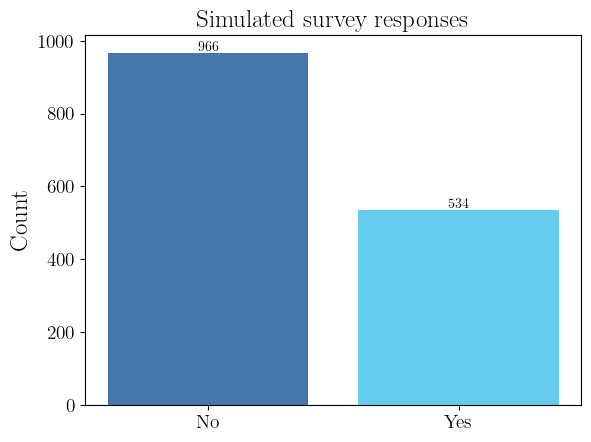

In [3]:
counts = np.array([n - tot, tot])
labels = ["No", "Yes"]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=cl.nbviz.tol_colors(len(labels)))
ax.set_title("Simulated survey responses")
ax.set_ylabel("Count")
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
            ha="center", va="bottom")
plt.show()


## Bernoulli / Binomial model

If each response is Bernoulli,
$$
Y_i \sim \Bern(p),\quad i=1,\dots,n,
$$
then the total number of Yes responses
$$
T=\sum_{i=1}^n Y_i
$$
has a binomial distribution:
$$
T \sim \Bin(n,p).
$$

We estimate $p=\mu$ with $\Ybar = T/n$.

### Standard error (CLT / Normal approximation)

By the Central Limit Theorem, for large $n$, the sampling distribution of $\Ybar$ is approximately normal:
$$
\Ybar \approx \mathcal{N}\!\left(p,\; \frac{p(1-p)}{n}\right).
$$

Replacing $p$ with $\Ybar$ gives the estimated standard error:
$$
\widehat{\mathrm{SE}}(\Ybar)=\sqrt{\frac{\Ybar(1-\Ybar)}{n}}.
$$


## Confidence intervals

We compute two intervals:

1. **Exact (Binomial) interval** via `scipy.stats.binomtest(...).proportion_ci(...)`
2. **CLT (Normal approximation) interval** (Wald):  
   $$
   \Ybar \pm \zalpha\sqrt{\frac{\Ybar(1-\Ybar)}{n}}.
   $$

> The CLT/Wald interval is simple, but it can behave poorly for small samples or when $\Ybar$ is very close to 0 or 1.


In [4]:
# 1) Exact binomial confidence interval (Clopper–Pearson-style)
bt = stats.binomtest(tot, n=n, p=0.5)  # p is irrelevant for the CI call; scipy uses tot,n
ci_exact = bt.proportion_ci(confidence_level=1-alpha, method="exact")

# 2) CLT / Wald interval
z = stats.norm.ppf(1 - alpha/2)
se_hat = math.sqrt(ybar * (1 - ybar) / n)
ci_clt = (max(0.0, ybar - z * se_hat), min(1.0, ybar + z * se_hat))

## Report the estimate and intervals

In [5]:
def fmt_pct(x):
    return f"{100*x:.1f}%"

print(f"Sample size, n = {n}")
print(f"Yes count = {tot}")
print(f"Point estimate ybar = {ybar:.4f} ({fmt_pct(ybar)})")
print()
print(f"{int((1-alpha)*100)}% exact (binomial) CI: [{ci_exact.low:.4f}, {ci_exact.high:.4f}]  "
      f"= [{fmt_pct(ci_exact.low)}, {fmt_pct(ci_exact.high)}]")
print(f"{int((1-alpha)*100)}% CLT (Wald) CI:       [{ci_clt[0]:.4f}, {ci_clt[1]:.4f}]  "
      f"= [{fmt_pct(ci_clt[0])}, {fmt_pct(ci_clt[1])}]")


Sample size, n = 1500
Yes count = 534
Point estimate ybar = 0.3560 (35.6%)

95% exact (binomial) CI: [0.3317, 0.3808]  = [33.2%, 38.1%]
95% CLT (Wald) CI:       [0.3318, 0.3802]  = [33.2%, 38.0%]


## How do the intervals compare?

- The **exact** interval is derived from the binomial model with no normal approximation.
- The **CLT/Wald** interval uses a normal approximation and plugs in $\Ybar$ for $p$.

For moderate to large $n$ and proportions not near 0 or 1, they are often similar.

Here we compare the empirical coverage of the two.

In [6]:
# Optional: Monte Carlo check of approximate coverage (quick demo).
# Increase reps for a more stable estimate.
reps = 5000
p0 = p_true

def ci_exact_for_k_vec(k, n, alpha=0.05):
    """
    Exact (Clopper–Pearson) CI for Bernoulli proportion.
    Vectorized interface (internally loops; exact CI is scalar).
    """
    k = np.asarray(k, dtype=int)
    lo = np.empty_like(k, dtype=float)
    hi = np.empty_like(k, dtype=float)
    for i, ki in np.ndenumerate(k):
        bt = stats.binomtest(int(ki), n=n, p=0.5)
        ci = bt.proportion_ci(confidence_level=1 - alpha, method="exact")
        lo[i], hi[i] = ci.low, ci.high
    return lo, hi

def wald_ci_for_k(k, n, alpha=0.05):
    """
    Wald (CLT) confidence interval for a Bernoulli proportion,
    based on counts k out of n. Vectorized and clipped to [0,1].
    """
    k = np.asarray(k, dtype=float)
    ph = k / n
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.sqrt(ph * (1 - ph) / n)
    lo = np.clip(ph - z * se, 0.0, 1.0)
    hi = np.clip(ph + z * se, 0.0, 1.0)
    return lo, hi

ks = rng.binomial(n=n, p=p0, size=reps)
lo_exact, hi_exact = ci_exact_for_k_vec(ks, n, alpha=alpha)
lo_wald,  hi_wald  = wald_ci_for_k(ks, n, alpha=alpha)
cover_exact = np.mean((lo_exact <= p0) & (p0 <= hi_exact))
cover_wald  = np.mean((lo_wald  <= p0) & (p0 <= hi_wald))

print(f"Monte Carlo estimated coverage at p={p0:.3f}, n={n}, reps={reps}:")
print(f"  Exact CI coverage ≈ {cover_exact:.3f}")
print(f"  CLT/Wald coverage ≈ {cover_wald:.3f}")

Monte Carlo estimated coverage at p=0.360, n=1500, reps=5000:
  Exact CI coverage ≈ 0.951
  CLT/Wald coverage ≈ 0.946


## Interpreting a confidence interval

A $95\%$ confidence interval procedure has the property that **in repeated sampling**, about $95\%$ of the intervals produced will contain the true $p$.

It does **not** mean: “there is a 95% probability that $p$ lies in this particular computed interval.”

Let's look at the distrubution of sample proportions for the CLT confidence intervals

In [7]:
def simulate_wald_coverage(R, n, p, *, rng, alpha=0.05):
    y = rng.binomial(1, p, size=(R, n))
    k = y.sum(axis=1)
    lo, hi = wald_ci_for_k(k, n, alpha=alpha)
    ybar = k / n
    cover = (lo <= p) & (p <= hi)
    return ybar, lo, hi, cover

ybar, lo, hi, cover = simulate_wald_coverage(reps, n, p_true, rng=rng, alpha=alpha)
coverage = cover.mean()

### Plotting the simulation
Notice that the histogram of the sample means, $\Ybar$, resembles a normal distribution.

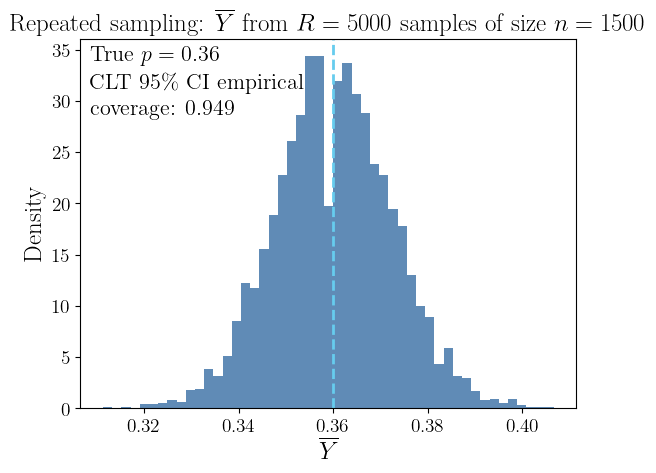

In [8]:
fig, ax = plt.subplots()

ax.hist(ybar, bins="auto", density=True, alpha=0.85, color=cl.nbviz.tol_colors(2)[0])
ax.axvline(p_true, linestyle="--", linewidth=2, color=cl.nbviz.tol_colors(2)[1])

ax.set_title(fr"Repeated sampling: $\overline{{Y}}$ from $R={reps}$ samples of size $n={n}$")
ax.set_xlabel(r"$\overline{Y}$")
ax.set_ylabel("Density")

ax.text(
    0.02, 0.98,
    fr"True $p={p_true}$" 
    "\n" 
    r"CLT 95\% CI empirical" 
    "\n" 
    fr" coverage: {coverage:.3f}",
    transform=ax.transAxes,
    va="top",
    fontsize=16,       
    linespacing=1.4    
)
cl.nbviz.savefig("ybar_histogram_approval")

### Next we show how often the CLT confidence interval is valid
Notice that some confidence intervals are wrong.  This is to be expeted.

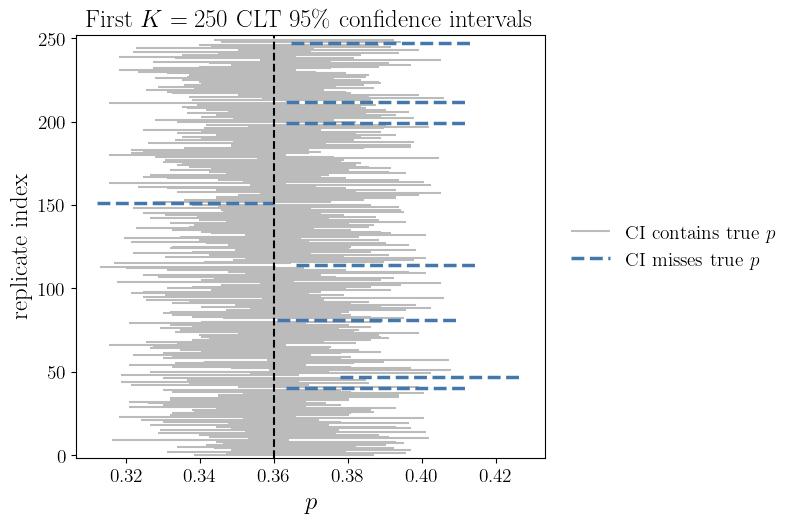

In [9]:
K = 250  #number to show
idx = np.arange(K)
hit = cover[:K]
miss = ~hit
fig, ax = plt.subplots(figsize=(7.5, 5.5))

# Hits: solid gray
ax.hlines(
    idx[hit],
    lo[:K][hit],
    hi[:K][hit],
    lw=1.5,
    color=colors["gray"],
    alpha=1.0,
    label="CI contains true $p$"
)

# Misses: dashed blue
ax.hlines(
    idx[miss],
    lo[:K][miss],
    hi[:K][miss],
    lw=2.5,
    linestyle="--",
    color=colors["blue"],
    alpha=1.0,
    label="CI misses true $p$"
)

# True parameter
ax.axvline(p_true, linestyle="--", color="black", lw=1.5)
ax.set_title(fr"First $K={K}$ CLT 95\% confidence intervals")
ax.set_xlabel("$p$")
ax.set_ylabel("replicate index")
ax.set_ylim(-2, K+2)
# Legend outside to the right
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
# Make room for the legend
fig.subplots_adjust(right=0.75)
cl.nbviz.savefig("ci_failure_approval")